In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

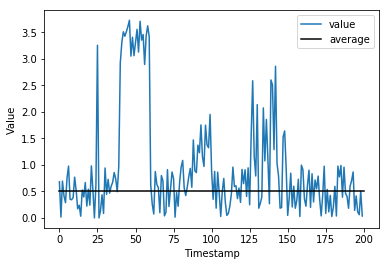

In [64]:
COLUMNS = ['timestamp', 'value']

class OutlierGenerator:
    def __init__(self, timestamp):
        self.timestamp = timestamp
        
    def get_value(self):
        pass
        
        
class ExtremeOutlierGenerator(OutlierGenerator):
    def __init__(self, timestamps=[], value=None):
        self.timestamps = timestamps
        self.value = value
        self.PREVIOUS_MEAN = None
        self.VALUE_FACTOR = 5
        
    def get_value(self, current_timestamp, previous_df):
        if current_timestamp in self.timestamps:
            if self.value is None:
                if self.PREVIOUS_MEAN is None:
                    self.PREVIOUS_MEAN = previous_df['value'].mean()
                return np.random.random() + self.PREVIOUS_MEAN * self.VALUE_FACTOR
            else:
                return self.value
        else:
            return 0

class ShiftOutlierGenerator(OutlierGenerator):
    def __init__(self, timestamps=[], value=None, shift_value=None):
        self.timestamps = timestamps
        self.value = value
        self.SHIFT_VALUE = shift_value
        self.MEAN_FACTOR = 5
        self.ongoing_shift = False
        
    def get_value(self, current_timestamp, previous_df):
        if current_timestamp in [end for _, end in self.timestamps]:
            self.ongoing_shift = False
            
        if current_timestamp in [start for start, _ in self.timestamps] or self.ongoing_shift:
            self.ongoing_shift = True
            if self.value is None:
                if self.SHIFT_VALUE is None:
                    self.SHIFT_VALUE = previous_df['value'].mean() * self.MEAN_FACTOR
                return np.random.random() + self.SHIFT_VALUE
            else:
                return self.value   
        else:
            return 0
        
        
class TrendOutlierGenerator(OutlierGenerator):
    def __init__(self, timestamps=[], trend_value=0.06):
        self.timestamps = timestamps
        self.TREND_VALUE = trend_value
        self.trend_since = 0
        self.ongoing_trend = False
        
    def get_value(self, current_timestamp, previous_df):
        if current_timestamp in [end for _, end in self.timestamps]:
            self.ongoing_trend = False
            self.trend_since = 0
            
        if current_timestamp in [start for start, _ in self.timestamps] or self.ongoing_trend:
            self.ongoing_trend = True
            self.trend_since += 1
            return np.random.random() + self.TREND_VALUE * self.trend_since  
        else:
            return 0
        

class VarianceOutlierGenerator(OutlierGenerator):
    def __init__(self, timestamps=[], variance_factor=3):
        self.timestamps = timestamps
        self.VARIANCE_FACTOR = variance_factor
        self.ongoing_variance = False
        
    def get_value(self, current_timestamp, previous_df):
        if current_timestamp in [end for _, end in self.timestamps]:
            self.ongoing_variance = False
            
        if current_timestamp in [start for start, _ in self.timestamps] or self.ongoing_variance:
            self.ongoing_variance = True
            return np.random.random() * self.VARIANCE_FACTOR
        else:
            return 0


class DataGenerator:
    def __init__(self, stream_length, extreme_gen=ExtremeOutlierGenerator(), shift_gen=ShiftOutlierGenerator(),
                 trend_gen=TrendOutlierGenerator(), variance_gen=VarianceOutlierGenerator()):
        self.stream_length = stream_length
        self.extreme_gen = extreme_gen
        self.shift_gen = shift_gen
        self.trend_gen = trend_gen
        self.variance_gen = variance_gen
        
    def run(self):
        df = pd.DataFrame(columns=COLUMNS)
        extreme_gen = ExtremeOutlierGenerator()
        shift_gen = ShiftOutlierGenerator()

        for i in range(self.stream_length):
            value = 0

            for generator in [self.extreme_gen, self.shift_gen, self.trend_gen, self.variance_gen]:
                value += generator.get_value(i, df)
                
            if value == 0:
                value = np.random.random()

            series = dict(zip(COLUMNS, [i, value]))
            df = df.append(series, ignore_index=True)
        return df

STREAM_LENGTH = 200
extreme_gen = ExtremeOutlierGenerator(timestamps=[25])
shift_gen = ShiftOutlierGenerator(timestamps=[(40, 60)])
trend_gen = TrendOutlierGenerator(timestamps=[(80, 100)])
variance_gen = VarianceOutlierGenerator(timestamps=[(125, 150)])

dg = DataGenerator(STREAM_LENGTH, extreme_gen=extreme_gen,
                   shift_gen=shift_gen, trend_gen=trend_gen, variance_gen=variance_gen)
df = dg.run()

plt.plot(df['value'])
plt.plot([0, 200], [0.5, 0.5], 'k-', label='average')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()